# FEATURE CORRELATION

Add root folder to the path in order we can use local modules:

In [1]:
import sys
sys.path.append('../..')

Get current directory:

In [2]:
import os
os.getcwd()

'/Users/porfirioads/Workspace/mcpi/mcpi-tesis-backend/app/notebooks'

Read dataset:

In [4]:
from app.services.dataset_service import DatasetService

dataset_service = DatasetService()

df = dataset_service.read_dataset(
    file_path='../../resources/cleaned/cle_respuestas_form_1671341451_1671381775.csv',
    encoding='utf-8',
    delimiter=','
)

df['sentiment'] = df['sentiment'].astype('category').cat.codes

In [5]:
df.head()

,sentiment,answer,length,cc,vbp,cd,dt,ex,fw,inn,...,vbz,wdt,wp,wrb,pos_length,neg_length,pos_acumulado,neg_acumulado,polarity,cant_caracteres
0,1,planting shade trees along city walks to reduc...,21,1,0,0,0,0,0,2,...,0,0,0,0,0,2,0.000000,-0.333333,-0.166667,133
1,0,tucson for the most part is not walkable what...,35,0,1,0,2,0,0,6,...,1,0,1,0,1,1,0.500000,-0.166667,0.111111,208
2,1,"tree planting, green space, restrict new devel...",12,0,0,0,0,0,0,0,...,1,1,0,0,2,1,0.272727,-0.200000,0.024242,80
3,1,"truly, it seems that vehicle pollution in tucs...",23,0,1,0,3,0,0,4,...,2,0,0,0,1,0,0.062500,0.000000,0.031250,124
4,1,encouraging and promoting alternative forms of...,26,2,0,0,3,0,0,3,...,0,0,0,0,1,1,0.600000,-0.200000,0.200000,211


Show heatmap

/var/folders/84/h0j6pvp57g38c23_hghd2n9c0000gn/T/ipykernel_8661/742756398.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, fmt='.1f', cmap='coolwarm')


<AxesSubplot: >

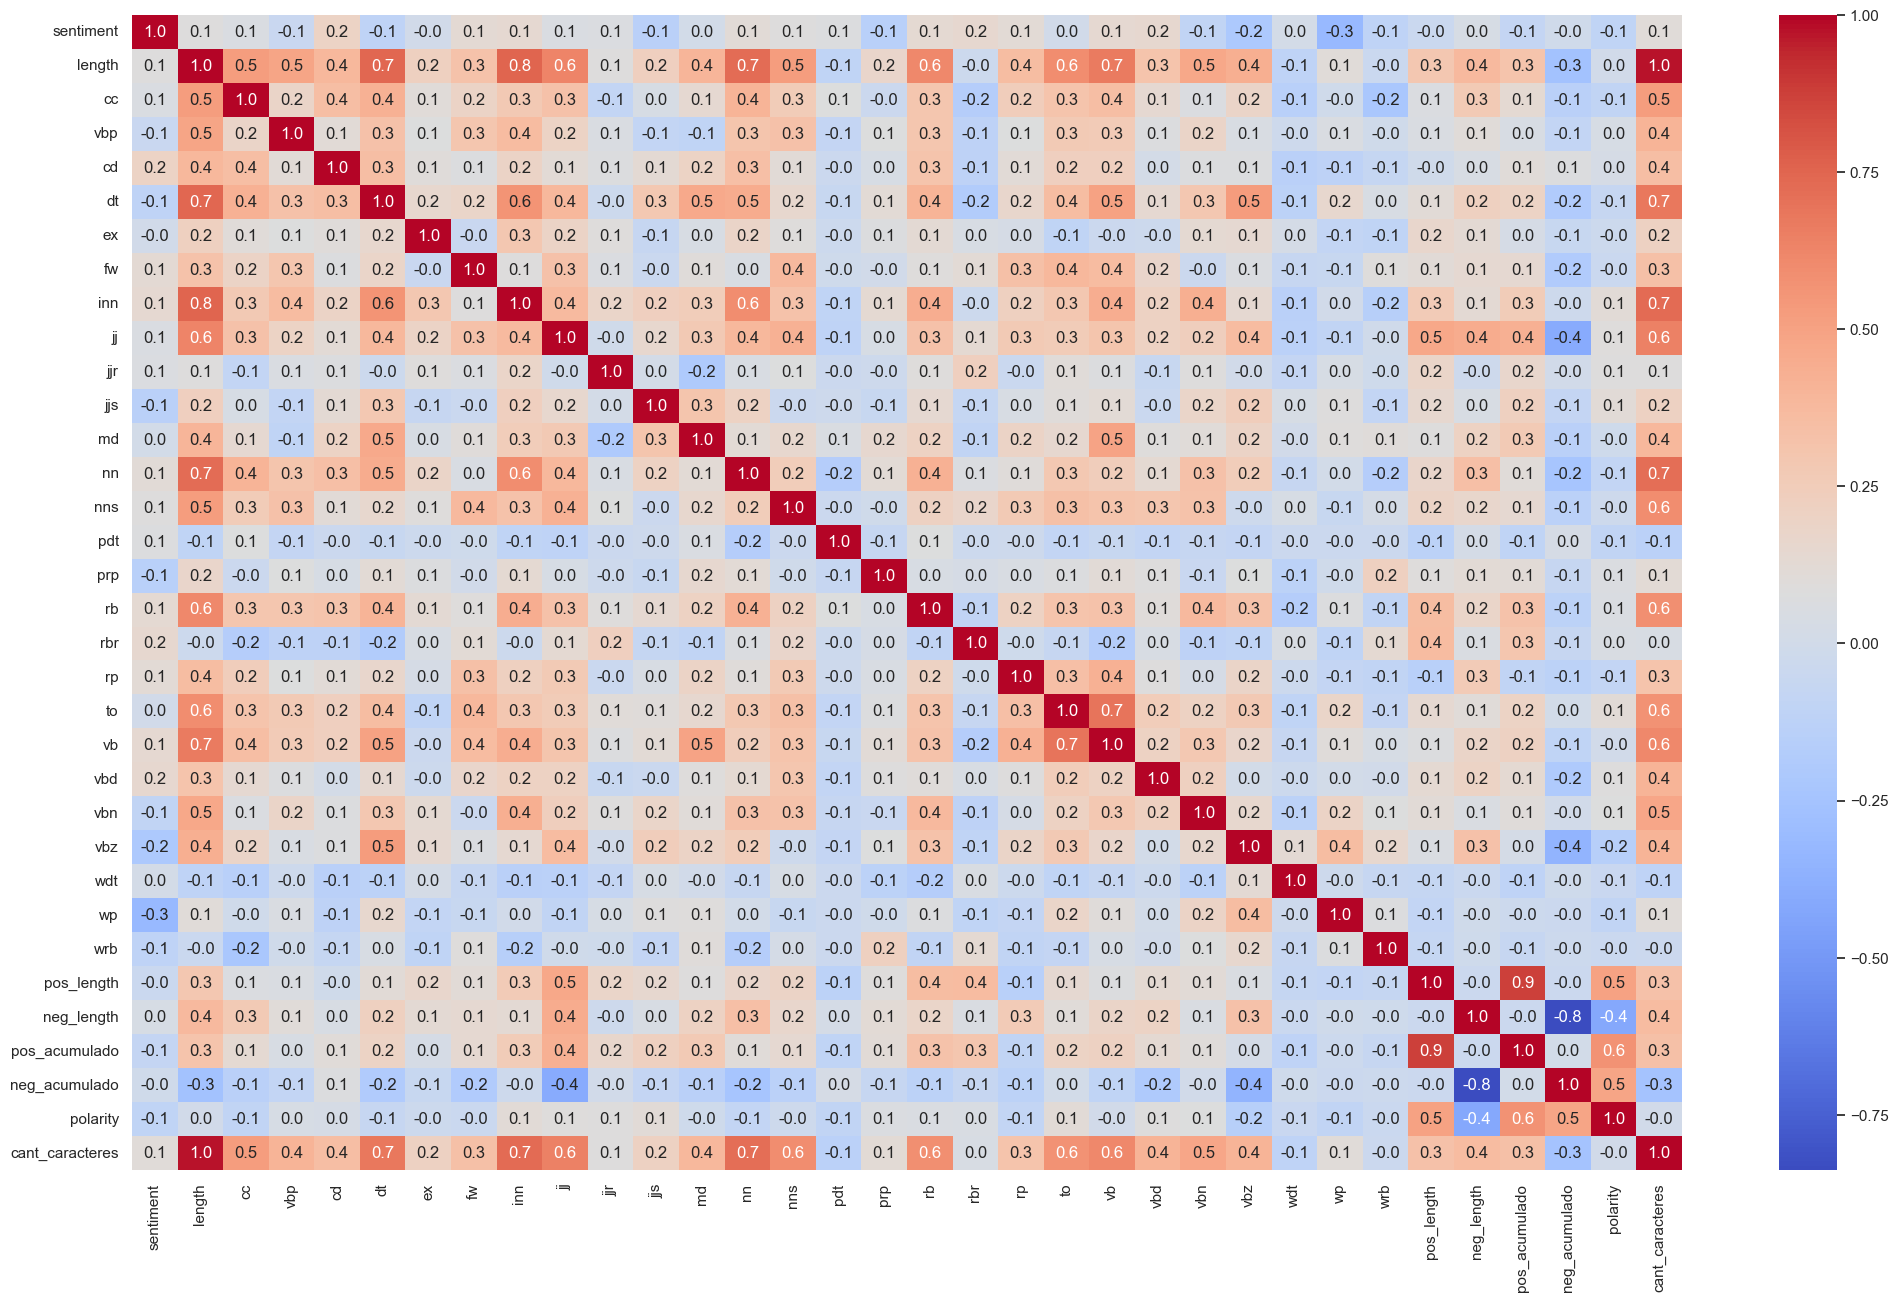

In [6]:
import seaborn as sns

sns.set(rc={'figure.figsize': (25, 15)})
sns.heatmap(df.corr(), annot=True, fmt='.1f', cmap='coolwarm')

## Preprocesamiento

<AxesSubplot: >

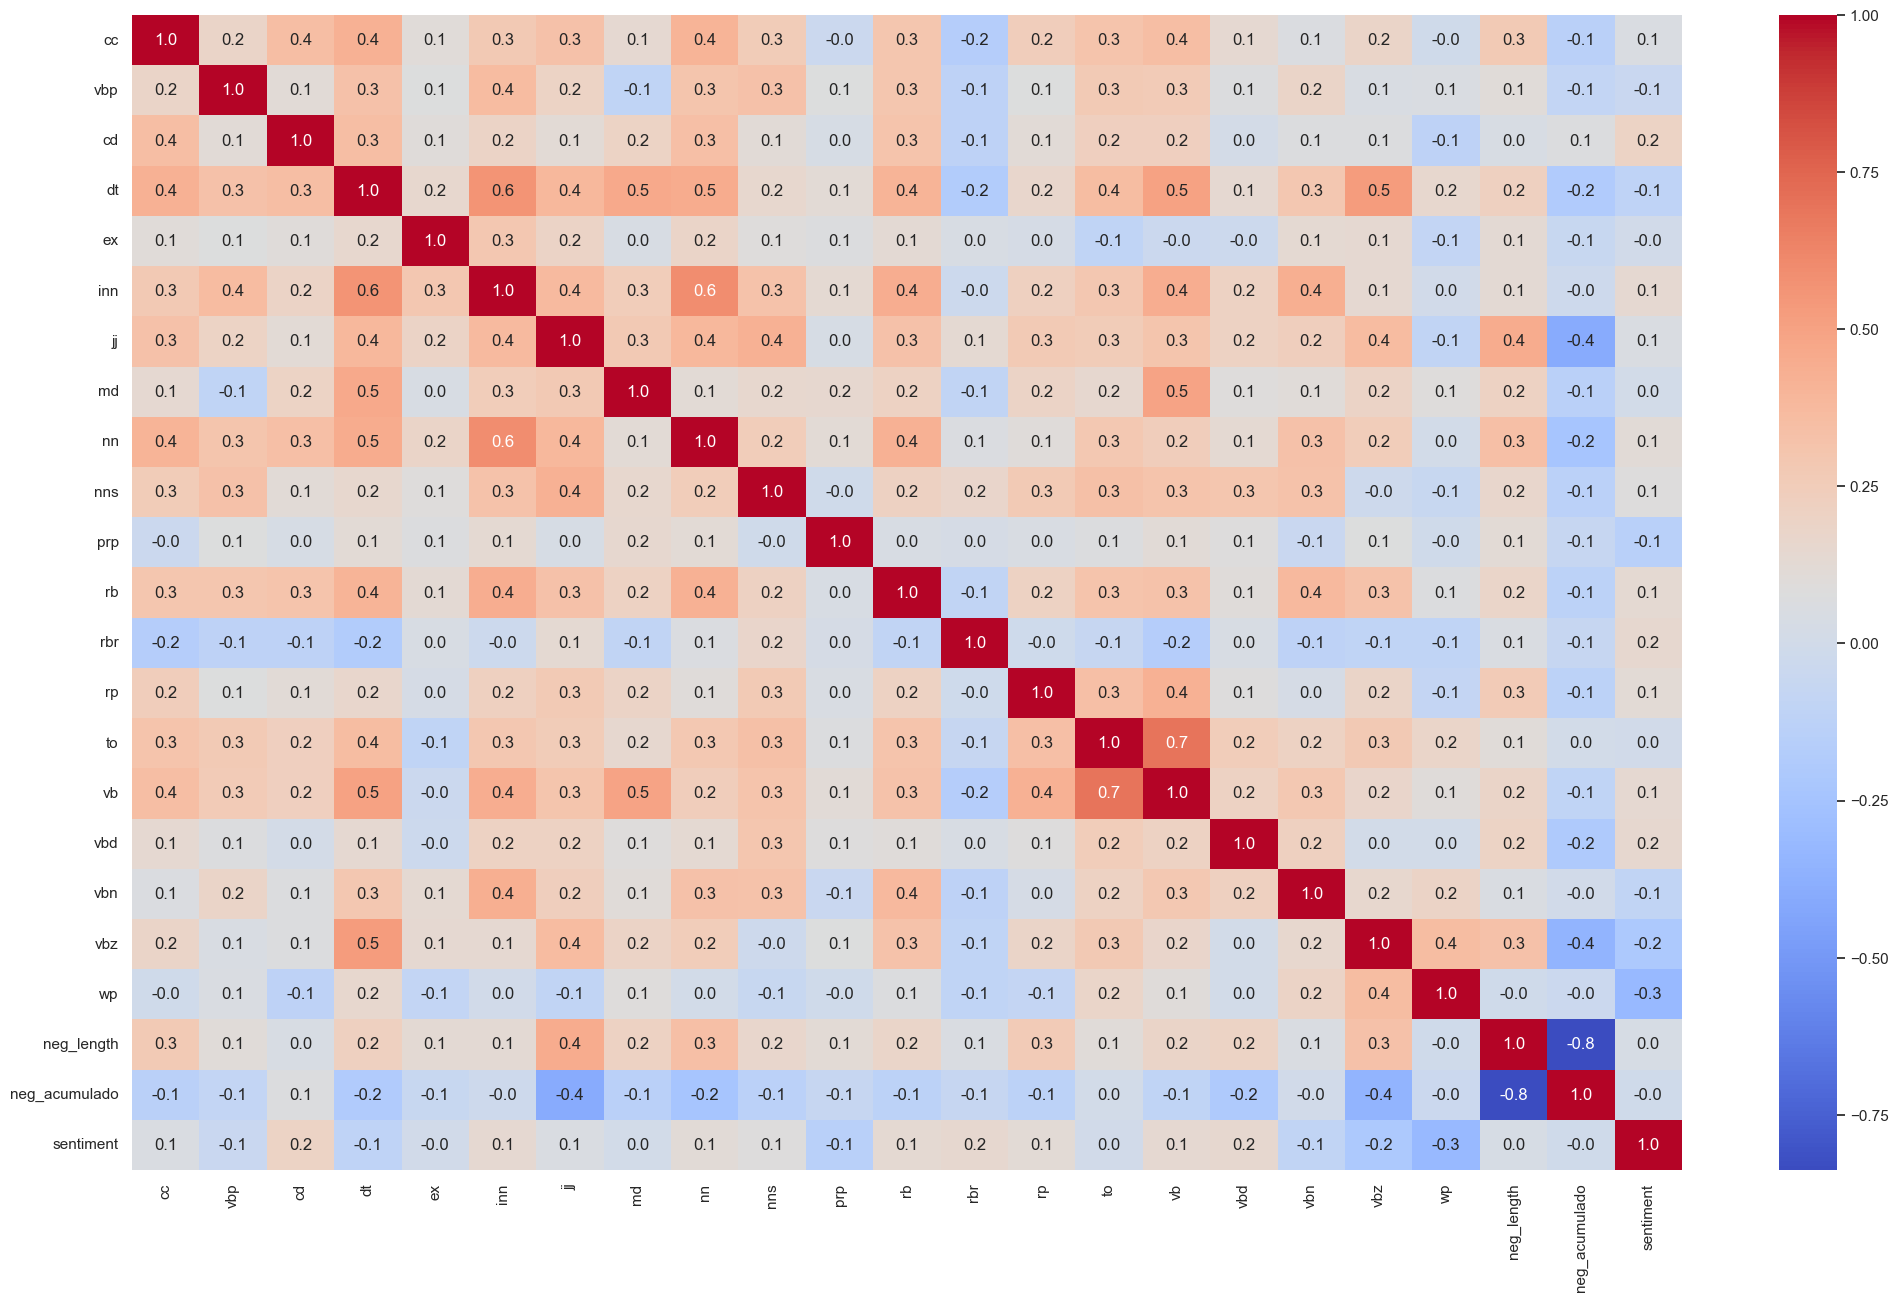

In [25]:
import statsmodels.api as sm
from sklearn import preprocessing
from scipy.stats import zscore
import numpy as np
import pandas as pd

data = df.copy()
data_ = data.sentiment
data = data.drop(columns=['sentiment', 'answer'])
data = data.apply(zscore)

# Correlation metrics
label_encoder = preprocessing.LabelEncoder()
data.iloc[:, data.shape[1] - 1] = label_encoder.fit_transform(
    data.iloc[:, 0]
).astype('float64')
corr = data.corr()


# Next, we compare the correlation between features
# and remove one of two features that have a correlation higher than 0.9
columns = np.full((corr.shape[0],), True, dtype=bool)

for i in range(corr.shape[0]):
    for j in range(i + 1, corr.shape[0]):
        if corr.iloc[i, j] >= 0.9:
            if columns[j]:
                columns[j] = False

selected_columns = data.columns[columns]
data = data[selected_columns]

# pvalue feature selection
selected_columns = selected_columns[1:].values


def backward_elimination(x, Y, sl, columns):
    numVars = len(x[0])
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(Y, x).fit()
        maxVar = max(regressor_OLS.pvalues).astype(float)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
                    columns = np.delete(columns, j)
    regressor_OLS.summary()
    return x, columns


data_modeled, selected_columns = backward_elimination(
    data.iloc[:, 1:].values,
    data.iloc[:, 0].values,
    0.05,
    selected_columns
)

# Creating a Dataframe with the columns selected using the p-value and correlation
fs_data = pd.DataFrame(data=data_modeled, columns=selected_columns)
fs_data['sentiment'] = data_
fs_data.head()

sns.heatmap(fs_data.corr(), annot=True, fmt='.1f', cmap='coolwarm')
